# Cubic spline with natural boundary condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def runge(x):
    return 1.0/(1.0 + 25.0*x*x)

def natural_cubic_spline_coeffs(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    if n < 2:
        raise ValueError("Need at least two points for a spline.")
    h = np.diff(x)  # n-1
    if np.any(h <= 0):
        raise ValueError("x must be strictly increasing.")

    a = y.copy()
    alpha = np.zeros(n)
    for i in range(1, n-1):
        alpha[i] = (3.0/h[i])*(a[i+1]-a[i]) - (3.0/h[i-1])*(a[i]-a[i-1])

    l = np.ones(n)
    mu = np.zeros(n)
    z = np.zeros(n)
    for i in range(1, n-1):
        l[i] = 2.0*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1])/l[i]

    c = np.zeros(n)
    b = np.zeros(n-1)
    d = np.zeros(n-1)
    for j in range(n-2, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - h[j]*(c[j+1]+2.0*c[j])/3.0
        d[j] = (c[j+1]-c[j])/(3.0*h[j])
    return a[:-1], b, c[:-1], d

def eval_spline(x, coeffs, t):
    a, b, c, d = coeffs
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)
    n = len(x)
    idx = np.searchsorted(x, t, side='right') - 1
    idx = np.clip(idx, 0, n-2)
    dt = t - x[idx]
    return a[idx] + b[idx]*dt + c[idx]*dt**2 + d[idx]*dt**3



In [3]:
n = 100
xs = np.linspace(-1.0, 1.0, n)
ys = runge(xs)
coeffs = natural_cubic_spline_coeffs(xs, ys)
xx = np.linspace(-1.0, 1.0, 1000)
fxx = runge(xx)
sxx = eval_spline(xs, coeffs, xx)


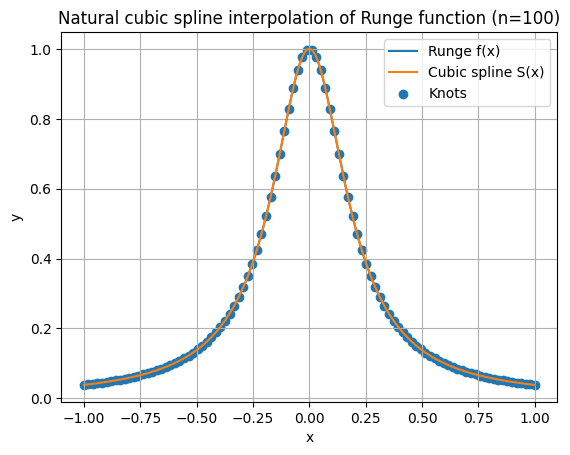

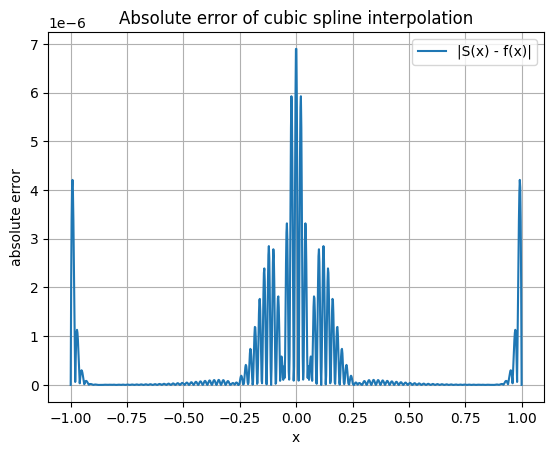

In [4]:
plt.figure()
plt.plot(xx, fxx, label="Runge f(x)")
plt.plot(xx, sxx, label="Cubic spline S(x)")
plt.scatter(xs, ys, marker='o', label="Knots")
plt.title(f"Natural cubic spline interpolation of Runge function (n={n})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
plt.figure()
plt.plot(xx, np.abs(sxx - fxx), label="|S(x) - f(x)|")
plt.title("Absolute error of cubic spline interpolation")
plt.xlabel("x")
plt.ylabel("absolute error")
plt.legend()
plt.grid(True)
plt.show()


# Cubic spline with clamped boundary condition

In [5]:
def runge(x):
    return 1.0/(1.0 + 25.0*x*x)

def runge_p(x):
    return -50.0*x/(1.0 + 25.0*x*x)**2


In [6]:
def cubic_spline_clamped_coeffs(x, y, s0, sn):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    n = len(x)
    if n < 2:
        raise ValueError("Need at least two points for a spline.")
    h = np.diff(x)
    if np.any(h <= 0):
        raise ValueError("x must be strictly increasing.")

    A = np.zeros((n, n))
    rhs = np.zeros(n)


    A[0, 0] = 2*h[0]
    A[0, 1] = h[0]
    rhs[0] = 3*((y[1] - y[0])/h[0] - s0)


    for i in range(1, n-1):
        A[i, i-1] = h[i-1]
        A[i, i]   = 2*(h[i-1] + h[i])
        A[i, i+1] = h[i]
        rhs[i] = 3*((y[i+1]-y[i])/h[i] - (y[i]-y[i-1])/h[i-1])

    A[n-1, n-2] = h[-1]
    A[n-1, n-1] = 2*h[-1]
    rhs[n-1] = 3*(sn - (y[-1]-y[-2])/h[-1])

    c = np.linalg.solve(A, rhs)
    a = y[:-1]
    b = (y[1:] - y[:-1])/h - h*(2*c[:-1] + c[1:])/3.0
    d = (c[1:] - c[:-1])/(3.0*h)
    return a, b, c[:-1], d

def eval_spline(x, coeffs, t):
    a, b, c, d = coeffs
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)
    idx = np.searchsorted(x, t, side='right') - 1
    idx = np.clip(idx, 0, len(x)-2)
    dt = t - x[idx]
    return a[idx] + b[idx]*dt + c[idx]*dt**2 + d[idx]*dt**3


In [11]:
n = 100
xs = np.linspace(-1.0, 1.0, n)
ys = runge(xs)

s0 = runge_p(xs[0])
sn = runge_p(xs[-1])

coeffs = cubic_spline_clamped_coeffs(xs, ys, s0, sn)

xx = np.linspace(-1.0, 1.0, 2000)
fxx = runge(xx)
sxx = eval_spline(xs, coeffs, xx)

abs_err = np.abs(sxx - fxx)
max_err = abs_err.max()
rmse = np.sqrt(np.mean(abs_err**2))

n = 100 clamped spline on [-1,1]
Max abs error: 6.995305e-06
RMSE:          9.214181e-07


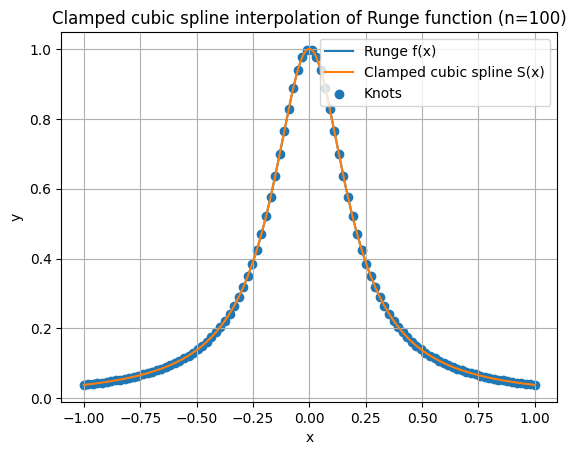

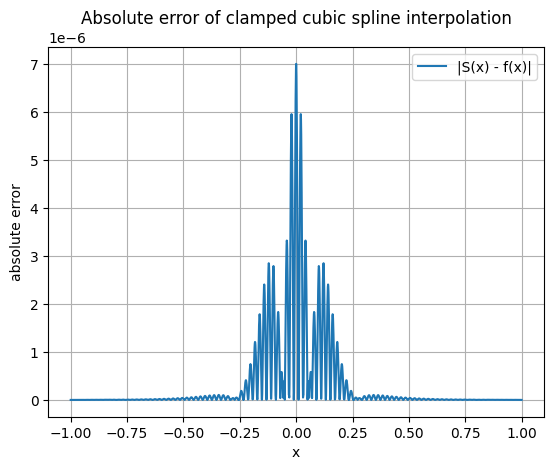

In [12]:
print(f"n = {n} clamped spline on [-1,1]")
print(f"Max abs error: {max_err:.6e}")
print(f"RMSE:          {rmse:.6e}")

plt.figure()
plt.plot(xx, fxx, label="Runge f(x)")
plt.plot(xx, sxx, label="Clamped cubic spline S(x)")
plt.scatter(xs, ys, marker='o', label="Knots")
plt.title(f"Clamped cubic spline interpolation of Runge function (n={n})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(xx, abs_err, label="|S(x) - f(x)|")
plt.title("Absolute error of clamped cubic spline interpolation")
plt.xlabel("x")
plt.ylabel("absolute error")
plt.legend()
plt.grid(True)
plt.show()

# Findin N such that $\lVert F-S \rVert _{\infty} \le 10^{-10}$

In [13]:
def coeffs_clamped(x, y, s0, sn):
    """Clamped cubic spline coefficients via tridiagonal solver. Returns (a,b,c,d,h)."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)
    h = np.diff(x)
    l = np.zeros(n-1); d = np.zeros(n); u = np.zeros(n-1); rhs = np.zeros(n)
    d[0] = 2*h[0]; u[0] = h[0]; rhs[0] = 3*((y[1]-y[0])/h[0] - s0)
    for i in range(1, n-1):
        l[i-1] = h[i-1]; d[i] = 2*(h[i-1] + h[i]); u[i] = h[i]
        rhs[i] = 3*((y[i+1]-y[i])/h[i] - (y[i]-y[i-1])/h[i-1])
    l[n-2] = h[-1]; d[n-1] = 2*h[-1]
    rhs[n-1] = 3*(sn - (y[-1]-y[-2])/h[-1])
    for i in range(1, n):
        w = l[i-1] / d[i-1]
        d[i]  -= w * u[i-1]
        rhs[i] -= w * rhs[i-1]
    cfull = np.empty(n)
    cfull[-1] = rhs[-1] / d[-1]
    for i in range(n-2, -1, -1):
        cfull[i] = (rhs[i] - u[i] * cfull[i+1]) / d[i]
    a = y[:-1]
    b = (y[1:] - y[:-1])/h - h*(2*cfull[:-1] + cfull[1:])/3.0
    dcoef = (cfull[1:] - cfull[:-1])/(3.0*h)
    return a, b, cfull[:-1], dcoef, h

In [14]:
def coeffs_natural(x, y):
    """Natural cubic spline coefficients (S''(x0)=S''(xn)=0) via tridiagonal solver. Returns (a,b,c,d,h)."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)
    h = np.diff(x)
    l = np.zeros(n-1); d = np.zeros(n); u = np.zeros(n-1); rhs = np.zeros(n)
    d[0] = 1.0; rhs[0] = 0.0
    for i in range(1, n-1):
        l[i-1] = h[i-1]; d[i] = 2*(h[i-1] + h[i]); u[i] = h[i]
        rhs[i] = 3*((y[i+1]-y[i])/h[i] - (y[i]-y[i-1])/h[i-1])
    d[n-1] = 1.0; rhs[n-1] = 0.0
    for i in range(1, n):
        w = l[i-1] / d[i-1]
        d[i]  -= w * u[i-1]
        rhs[i] -= w * rhs[i-1]
    cfull = np.empty(n)
    cfull[-1] = rhs[-1] / d[-1]
    for i in range(n-2, -1, -1):
        cfull[i] = (rhs[i] - u[i] * cfull[i+1]) / d[i]
    a = y[:-1]
    b = (y[1:] - y[:-1])/h - h*(2*cfull[:-1] + cfull[1:])/3.0
    dcoef = (cfull[1:] - cfull[:-1])/(3.0*h)
    return a, b, cfull[:-1], dcoef, h

In [29]:
def sup_error_for_N(N, boundary="clamped", samples_per_interval=100):
    """
    Estimate ||f - S||_inf for N equally-spaced nodes on [-1,1].
    boundary: "clamped" or "natural".
    """
    xs = np.linspace(-1.0, 1.0, N)
    ys = runge(xs)
    if boundary == "clamped":
        s0, sn = runge_p(xs[0]), runge_p(xs[-1])
        a, b, c, d, h = coeffs_clamped(xs, ys, s0, sn)
    elif boundary == "natural":
        a, b, c, d, h = coeffs_natural(xs, ys)
    else:
        raise ValueError("boundary must be 'clamped' or 'natural'")
    s = samples_per_interval
    hval = h[0]
    t_local = np.linspace(0.0, hval, s)
    X = (xs[:-1, None] + t_local[None, :]).ravel()
    dt = np.tile(t_local, N-1)
    rep = np.repeat(np.arange(N-1), s)
    Svals = a[rep] + b[rep]*dt + c[rep]*dt**2 + d[rep]*dt**3
    Fvals = runge(X)
    S_right = ys[-1]; F_right = runge(xs[-1])
    return max(np.max(np.abs(Svals - Fvals)), abs(S_right - F_right))


In [30]:
def find_min_N(tol=1e-10, boundary="clamped", startN=10, samples_per_interval=100, maxN=1<<20):
    """
    Find the smallest N such that sup_error_for_N(N) < tol.
    Uses exponential search to find an upper bound, then binary search.
    """
    N = startN
    err = sup_error_for_N(N, boundary, samples_per_interval)
    while err >= tol:
        N *= 2
        if N > maxN:
            raise RuntimeError("N exceeded maxN while searching for tolerance.")
        err = sup_error_for_N(N, boundary, samples_per_interval)
    upperN, upperErr = N, err
    lowerN = N // 2
    lowerErr = sup_error_for_N(lowerN, boundary, samples_per_interval)
    lo, hi = lowerN + 1, upperN
    bestN, bestErr = upperN, upperErr
    while lo <= hi:
        mid = (lo + hi) // 2
        midErr = sup_error_for_N(mid, boundary, samples_per_interval)
        if midErr < tol:
            bestN, bestErr = mid, midErr
            hi = mid - 1
        else:
            lo = mid + 1
    return {
        "boundary": boundary,
        "tol": tol,
        "samples_per_interval": samples_per_interval,
        "lower_bracket": (lowerN, lowerErr),
        "upper_bracket": (upperN, upperErr),
        "minimal_N": bestN,
        "error_at_minimal_N": bestErr
    }


# Condition= clamped with tol= $10^{-10}$



In [31]:
result = find_min_N(tol=1e-10, boundary="clamped", startN=10, samples_per_interval=100)
result

{'boundary': 'clamped',
 'tol': 1e-10,
 'samples_per_interval': 100,
 'lower_bracket': (1280, np.float64(2.3361934609056334e-10)),
 'upper_bracket': (2560, np.float64(1.457345355504458e-11)),
 'minimal_N': 1583,
 'error_at_minimal_N': np.float64(9.977729753529729e-11)}

# Condition= clamped with tol=  $10^{−5}$

In [32]:
result = find_min_N(tol=1e-5, boundary="clamped", startN=10, samples_per_interval=100)
result

{'boundary': 'clamped',
 'tol': 1e-05,
 'samples_per_interval': 100,
 'lower_bracket': (80, np.float64(1.811863691703053e-05)),
 'upper_bracket': (160, np.float64(1.007240666872633e-06)),
 'minimal_N': 91,
 'error_at_minimal_N': np.float64(9.949229302641527e-06)}

# Condition = natural with tol=$10^{-10}$

In [33]:
result = find_min_N(tol=1e-10, boundary="natural", startN=10, samples_per_interval=100)
result

{'boundary': 'natural',
 'tol': 1e-10,
 'samples_per_interval': 100,
 'lower_bracket': (10240, np.float64(3.9428874748503873e-10)),
 'upper_bracket': (20480, np.float64(9.856256782958539e-11)),
 'minimal_N': 20333,
 'error_at_minimal_N': np.float64(9.999293060225511e-11)}

# Condition = natural with tol=$10^{-5}$

In [34]:
result = find_min_N(tol=1e-5, boundary="natural", startN=10, samples_per_interval=100)
result

{'boundary': 'natural',
 'tol': 1e-05,
 'samples_per_interval': 100,
 'lower_bracket': (80, np.float64(1.811863691703053e-05)),
 'upper_bracket': (160, np.float64(1.6344735609200023e-06)),
 'minimal_N': 91,
 'error_at_minimal_N': np.float64(9.949229302641527e-06)}

# Findin N such that $\lVert F-P \rVert _{\infty} \le 10^{-10}$

In [35]:
def equispaced_nodes(N, a=-1.0, b=1.0):
    return np.linspace(a, b, N)

def chebyshev_lobatto_nodes(N):
    j = np.arange(N)
    x = np.cos(np.pi * j / (N-1))
    return np.sort(x)

def bary_weights_cheb_lobatto(N):
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5 * ((-1)**(N-1))
    for j in range(1, N-1):
        w[j] = (-1)**j
    return w

In [36]:
def bary_weights_general(x):
    x = np.asarray(x, float)
    n = len(x)
    w = np.empty(n, float)
    for j in range(n):
        sign = -1 if ((n-1-j) % 2 == 1) else 1
        diffs = np.abs(x[j] - np.delete(x, j))
        s = -np.sum(np.log(diffs))
        w[j] = sign * np.exp(s)
    w /= np.max(np.abs(w))
    return w


In [37]:
def barycentric_eval(x, y, t, w=None, cheb=False):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    t = np.asarray(t, float)
    n = len(x)
    if w is None:
        w = bary_weights_general(x)
    out = np.empty_like(t)
    for k, tk in enumerate(t):
        diffs = tk - x
        zero_idx = np.where(diffs == 0)[0]
        if zero_idx.size > 0:
            out[k] = y[zero_idx[0]]
        else:
            inv = w / diffs
            out[k] = np.dot(inv, y) / np.sum(inv)
    return out


In [38]:
def sup_error_poly_bary(N, nodes="equispaced", grid_points=20000):
    if nodes == "equispaced":
        xs = equispaced_nodes(N)
        w = bary_weights_general(xs)
    elif nodes == "chebyshev":
        xs = chebyshev_lobatto_nodes(N)
        w = bary_weights_cheb_lobatto(N)
    else:
        raise ValueError("nodes must be 'equispaced' or 'chebyshev'")
    ys = runge(xs)
    xx = np.linspace(-1.0, 1.0, grid_points)
    fxx = runge(xx)
    pxx = barycentric_eval(xs, ys, xx, w=w)
    return float(np.max(np.abs(fxx - pxx)))

In [39]:
def find_min_N_poly_bary(tol=1e-10, nodes="chebyshev", startN=5, maxN=4096, grid_points=20000):
    N = startN
    err = sup_error_poly_bary(N, nodes, grid_points)
    while err >= tol and N < maxN:
        N *= 2
        err = sup_error_poly_bary(N, nodes, grid_points)
    if err >= tol and N >= maxN:
        return None
    upperN, upperErr = N, err
    lowerN = N // 2
    lowerErr = sup_error_poly_bary(lowerN, nodes, grid_points)
    lo, hi = lowerN + 1, upperN
    bestN, bestErr = upperN, upperErr
    while lo <= hi:
        mid = (lo + hi) // 2
        midErr = sup_error_poly_bary(mid, nodes, grid_points)
        if midErr < tol:
            bestN, bestErr = mid, midErr
            hi = mid - 1
        else:
            lo = mid + 1
    return {"nodes": nodes, "tol": tol, "lower_bracket": (lowerN, lowerErr),
            "upper_bracket": (upperN, upperErr), "minimal_N": bestN, "error_at_minimal_N": bestErr}


# TOL=$10^{-10}$

In [47]:
res_ch_bary = find_min_N_poly_bary(tol=1e-10, nodes="chebyshev", startN=5, maxN=2048, grid_points=5000)

res_ch_bary

{'nodes': 'chebyshev',
 'tol': 1e-10,
 'lower_bracket': (80, 2.9891463992903766e-07),
 'upper_bracket': (160, 3.752553823233029e-14),
 'minimal_N': 121,
 'error_at_minimal_N': 4.247313611926984e-11}

# TOL=$10^{-5}

In [49]:
res_ch_bary = find_min_N_poly_bary(tol=1e-5, nodes="chebyshev", startN=5, maxN=2048, grid_points=5000)

res_ch_bary

{'nodes': 'chebyshev',
 'tol': 1e-05,
 'lower_bracket': (40, 0.0008456465134567548),
 'upper_bracket': (80, 2.9891463992903766e-07),
 'minimal_N': 63,
 'error_at_minimal_N': 4.2779581409524425e-06}